In [1]:
import os
import os.path as op
import pandas as pd
import h5py
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy.io
from scipy.ndimage import gaussian_filter1d
from mne.io import read_epochs_eeglab
from mne.stats import permutation_cluster_1samp_test, ttest_1samp_no_p
from functools import partial

In [2]:
pipeline='NEARICA_behav'
ages=['9m','12m','adult']

condition_epochs={
    'exe': ['LEXT','FTGE','EXGC','EXEND'],
    'obs': ['LOBS','FTGO','OBGC','OBEND']
}

epoch_time_limits={
    'LEXT': [-1500,1000],
    'FTGE': [-500,1000],
    'EXGC': [-1000,1500],
    'EXEND': [-1500,1500],
    'LOBS': [-1500,1000],
    'FTGO': [-500,1000],
    'OBGC': [-1000,1500],
    'OBEND': [-1500,1500],
}

def load_bursts(pipeline, age):
    bursts = {
        'age': [],
        'subject': [],
        'chan': [],
        'cluster': [],
        'epoch': [],
        'fwhm_freq': [],
        'fwhm_time': [],
        'peak_adjustment': [],
        'peak_amp_base': [],
        'peak_amp_iter': [],
        'peak_freq': [],
        'peak_time': [],
        'polarity': [],
        'trial': [],
        'waveform': [],        
        'waveform_times': []
    }

    subjects=pd.read_csv(op.join('/home/bonaiuto/dev_beta_umd/data',age,'data/participants.tsv'), sep='\t')
    for subject in subjects['participant_id']:
        print('loading {}'.format(subject))
        fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,subject,'processed_data/processed_bursts.mat')
        if os.path.exists(fname):
            with h5py.File(fname, 'r') as f:
                bursts['age'].extend([age for x in list(f['bursts']['trial'])])
                bursts['subject'].extend([subject for x in list(f['bursts']['trial'])])
                bursts['chan'].extend(list(np.squeeze(f['bursts']['chan'][:])))
                bursts['cluster'].extend([u''.join(chr(c) for c in np.squeeze(f[obj_ref][:])) for obj_ref in np.squeeze(f['bursts']['cluster'][:])])
                bursts['epoch'].extend([u''.join(chr(c) for c in np.squeeze(f[obj_ref][:])) for obj_ref in np.squeeze(f['bursts']['epoch'][:])])
                bursts['fwhm_freq'].extend(list(np.squeeze(f['bursts']['fwhm_freq'][:])))
                bursts['fwhm_time'].extend(list(np.squeeze(f['bursts']['fwhm_time'][:])))
                bursts['peak_adjustment'].extend(list(np.squeeze(f['bursts']['peak_adjustment'][:])))
                bursts['peak_amp_base'].extend(list(np.squeeze(f['bursts']['peak_amp_base'][:])))
                bursts['peak_amp_iter'].extend(list(np.squeeze(f['bursts']['peak_amp_iter'][:])))
                bursts['peak_freq'].extend(list(np.squeeze(f['bursts']['peak_freq'][:])))
                bursts['peak_time'].extend(list(np.squeeze(f['bursts']['peak_time'][:])))
                bursts['polarity'].extend(list(np.squeeze(f['bursts']['polarity'][:])))
                bursts['trial'].extend(list(np.squeeze(f['bursts']['trial'][:])))
                for i in range(f['bursts']['waveform'][:,:].shape[1]):
                    bursts['waveform'].append(f['bursts']['waveform'][:,i])
                bursts['waveform_times']=f['bursts']['waveform_times'][:]
                
    bursts['age']=np.array(bursts['age'])
    bursts['subject']=np.array(bursts['subject'])
    bursts['chan']=np.array(bursts['chan'])
    bursts['cluster']=np.array(bursts['cluster'])
    bursts['epoch']=np.array(bursts['epoch'])
    bursts['fwhm_freq']=np.array(bursts['fwhm_freq'])
    bursts['fwhm_time']=np.array(bursts['fwhm_time'])
    bursts['peak_adjustment']=np.array(bursts['peak_adjustment'])
    bursts['peak_amp_base']=np.array(bursts['peak_amp_base'])
    bursts['peak_amp_iter']=np.array(bursts['peak_amp_iter'])
    bursts['peak_freq']=np.array(bursts['peak_freq'])
    bursts['peak_time']=np.array(bursts['peak_time'])
    bursts['polarity']=np.array(bursts['polarity'])
    bursts['trial']=np.array(bursts['trial'])
    bursts['waveform']=np.array(bursts['waveform'])
    bursts['waveform_times']=np.array(bursts['waveform_times'])
    
    return bursts

In [3]:
def filter_bursts(bursts, idx):
    
    filtered_bursts={
        'age': bursts['age'][idx],
        'subject': bursts['subject'][idx],
        'chan': bursts['chan'][idx],
        'cluster': bursts['cluster'][idx],
        'epoch': bursts['epoch'][idx],
        'fwhm_freq': bursts['fwhm_freq'][idx],
        'fwhm_time': bursts['fwhm_time'][idx],
        'peak_adjustment': bursts['peak_adjustment'][idx],
        'peak_amp_base': bursts['peak_amp_base'][idx],
        'peak_amp_iter': bursts['peak_amp_iter'][idx],
        'peak_freq': bursts['peak_freq'][idx],
        'peak_time': bursts['peak_time'][idx],
        'polarity': bursts['polarity'][idx],
        'trial': bursts['trial'][idx],
        'waveform': bursts['waveform'][idx,:],
        'waveform_times': bursts['waveform_times']
    }

    return filtered_bursts

In [4]:
def compute_rate(bursts, condition, cluster):
    bin_dt=25
    smth_kern=3
    
    epochs=condition_epochs[condition]
    base_epoch = epochs[0]
    
    c_rates={}
    epoch_bins={}
    for epoch in epochs:
        c_rates[epoch]=[]
        epoch_bins[epoch]=np.arange(epoch_time_limits[epoch][0],epoch_time_limits[epoch][1],bin_dt)
    epoch_time={}
    
    subjects=np.unique(bursts['subject'])
    
    for subj_idx,subject in enumerate(subjects):
        subj_rows=(bursts['subject']==subject)
        
        subj_c_rates={}
        for epoch_type in epochs:
            bins=epoch_bins[epoch_type]
            epoch_rows=(subj_rows) & (bursts['epoch']==epoch_type)
            trials=np.unique(bursts['trial'][epoch_rows])
        
            epoch_burst_rate=np.zeros((len(bins)-1))
            
            t_bursts=epoch_rows & (bursts['cluster']==cluster)
            hist, bin_edges = np.histogram(bursts['peak_time'][t_bursts], bins=bins)
            epoch_burst_rate=hist.astype(float)*(1000/bin_dt)
            epoch_burst_rate=gaussian_filter1d(epoch_burst_rate,smth_kern)

            if len(trials)>0:
                subj_c_rates[epoch_type]=epoch_burst_rate/len(trials)
                
        if base_epoch in subj_c_rates:
            b_t=(epoch_bins[base_epoch][:-1]>=epoch_time_limits[epoch_type][0]) & (epoch_bins[base_epoch][:-1]<0)
            mean_c_base=np.mean(subj_c_rates[base_epoch][b_t])
            for epoch_type in epochs:
                bins=epoch_bins[epoch_type]
                if epoch_type in subj_c_rates:                    
                    e_tidx=(bins[:-1]>=epoch_time_limits[epoch_type][0]) & (bins[:-1]<=epoch_time_limits[epoch_type][1])
                    epoch_time[epoch_type]=(bins[:-1])[e_tidx]
                    
                    if mean_c_base>0:
                        bc_c_rate=100.0*(subj_c_rates[epoch_type]-mean_c_base)/mean_c_base
                        if not np.any(np.isnan(bc_c_rate[e_tidx])):
                            c_rates[epoch_type].append(bc_c_rate[e_tidx])                    
                    
    for epoch_type in epochs:
        c_rates[epoch_type]=np.array(c_rates[epoch_type])

    return epoch_time, c_rates

In [5]:
def compute_power(age, pipeline, band_range, condition, cluster):
    
    subjects=pd.read_csv(op.join('/home/bonaiuto/dev_beta_umd/data',age,'data/participants.tsv'), sep='\t')
    epochs=condition_epochs[condition]
    base_epoch=epochs[0]

    c_tfs={}
    for epoch in epochs:
        c_tfs[epoch]=[]
    epoch_time={}

    for subject in subjects['participant_id']:
        subj_c_tfs={}
        for epoch_type in epochs:
            fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,subject,'processed_data/processed_superlet_tf_{}.mat'.format(epoch_type))
            if op.exists(fname):
                with h5py.File(fname, 'r') as f:
                    foi=np.array(f['foi'])[:,0]
                    time=np.array(f['time'])[:,0]
                    t_idx=(time>=-1500) & (time<=1500)
                    time=time[t_idx]
                    subj_c_tfs[epoch_type]=np.array(f['c_{}_tf'.format(cluster)])[t_idx,:].T
        if base_epoch in subj_c_tfs:
            b_t=(time>=epoch_time_limits[base_epoch][0]) & (time<0)
            mean_c_base=np.expand_dims(np.mean(subj_c_tfs[base_epoch][:,b_t],axis=1),1)
            for epoch_type in epochs:
                if epoch_type in subj_c_tfs:
                    bc_c_tf=100.0*(subj_c_tfs[epoch_type]-mean_c_base)/mean_c_base
                    
                    foi_idx=np.where((foi>=band_range[0]) & (foi<=band_range[1]))[0]
                    f=np.mean(bc_c_tf[foi_idx,:],axis=0)
                    e_tidx=(time>=epoch_time_limits[epoch_type][0]) & (time<=epoch_time_limits[epoch_type][1])
                    c_tfs[epoch_type].append(f[e_tidx])
                    epoch_time[epoch_type]=time[e_tidx]

    for epoch_type in epochs:
        c_tfs[epoch_type]=np.array(c_tfs[epoch_type])

    return epoch_time, c_tfs

In [6]:
c_bursts_9m=load_bursts(pipeline, '9m')

loading sub-010
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-023
loading sub-024
loading sub-025
loading sub-026
loading sub-027
loading sub-028
loading sub-029
loading sub-030
loading sub-031
loading sub-032
loading sub-033
loading sub-036
loading sub-037
loading sub-038
loading sub-041
loading sub-042
loading sub-043
loading sub-044


In [7]:
c_bursts_12m=load_bursts(pipeline, '12m')

loading sub-001
loading sub-002
loading sub-003
loading sub-004
loading sub-005
loading sub-006
loading sub-007
loading sub-008
loading sub-009
loading sub-010
loading sub-011
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-017
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-022
loading sub-023
loading sub-024
loading sub-025
loading sub-026
loading sub-027
loading sub-028
loading sub-029
loading sub-030
loading sub-031
loading sub-032
loading sub-033


In [8]:
c_bursts_adult=load_bursts(pipeline, 'adult')

loading sub-001
loading sub-002
loading sub-003
loading sub-004
loading sub-005
loading sub-006
loading sub-007
loading sub-008
loading sub-009
loading sub-010
loading sub-011
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-017
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-022


In [9]:
idx=np.where((c_bursts_9m['cluster']=='ipsi') | (c_bursts_9m['cluster']=='contra'))[0]
exe_c_bursts_9m=filter_bursts(c_bursts_9m, idx)

In [10]:
idx=np.where((c_bursts_12m['cluster']=='ipsi') | (c_bursts_12m['cluster']=='contra'))[0]
exe_c_bursts_12m=filter_bursts(c_bursts_12m, idx)

In [11]:
idx=np.where((c_bursts_adult['cluster']=='ipsi') | (c_bursts_adult['cluster']=='contra'))[0]
exe_c_bursts_adult=filter_bursts(c_bursts_adult, idx)

In [12]:
fname=op.join('/home/bonaiuto/dev_beta_umd/data/9m/derivatives',pipeline,'processed_psd.mat')
f = scipy.io.loadmat(fname)
fois=f['foi_ranges']
beta_idx=np.where(fois[:,1]<=30)[0][-1]
band_range_9m=fois[beta_idx,:]
print('9m: {}-{} Hz'.format(band_range_9m[0],band_range_9m[1]))

exe_epoch_time_9m, c_exe_ipsi_tfs_9m=compute_power('9m', pipeline, band_range_9m, 'exe', 'ipsi')
exe_epoch_time_9m, c_exe_contra_tfs_9m=compute_power('9m', pipeline, band_range_9m, 'exe', 'contra')
obs_epoch_time_9m, c_obs_ipsi_tfs_9m=compute_power('9m', pipeline, band_range_9m, 'obs', 'ipsi')
obs_epoch_time_9m, c_obs_contra_tfs_9m=compute_power('9m', pipeline, band_range_9m, 'obs', 'contra')

9m: 12.75-16.25 Hz


In [13]:
fname=op.join('/home/bonaiuto/dev_beta_umd/data/12m/derivatives',pipeline,'processed_psd.mat')
f = scipy.io.loadmat(fname)
fois=f['foi_ranges']
beta_idx=np.where(fois[:,1]<=30)[0][-1]
band_range_12m=fois[beta_idx,:]
print('12m: {}-{} Hz'.format(band_range_12m[0],band_range_12m[1]))

exe_epoch_time_12m, c_exe_ipsi_tfs_12m=compute_power('12m', pipeline, band_range_12m, 'exe', 'ipsi')
exe_epoch_time_12m, c_exe_contra_tfs_12m=compute_power('12m', pipeline, band_range_12m, 'exe', 'contra')
obs_epoch_time_12m, c_obs_ipsi_tfs_12m=compute_power('12m', pipeline, band_range_12m, 'obs', 'ipsi')
obs_epoch_time_12m, c_obs_contra_tfs_12m=compute_power('12m', pipeline, band_range_12m, 'obs', 'contra')

12m: 13.5-17.0 Hz


In [14]:
fname=op.join('/home/bonaiuto/dev_beta_umd/data/adult/derivatives',pipeline,'processed_psd.mat')
f = scipy.io.loadmat(fname)
fois=f['foi_ranges']
beta_idx=np.where(fois[:,1]<=30)[0][-1]
band_range_adult=fois[beta_idx,:]
print('adult: {}-{} Hz'.format(band_range_adult[0],band_range_adult[1]))

exe_epoch_time_adult, c_exe_ipsi_tfs_adult=compute_power('adult', pipeline, band_range_adult, 'exe', 'ipsi')
exe_epoch_time_adult, c_exe_contra_tfs_adult=compute_power('adult', pipeline, band_range_adult, 'exe', 'contra')
obs_epoch_time_adult, c_obs_ipsi_tfs_adult=compute_power('adult', pipeline, band_range_adult, 'obs', 'ipsi')
obs_epoch_time_adult, c_obs_contra_tfs_adult=compute_power('adult', pipeline, band_range_adult, 'obs', 'contra')

adult: 18.25-24.75 Hz


In [15]:
exe_epoch_bins_9m, c_exe_ipsi_rates_9m=compute_rate(c_bursts_9m,'exe', 'ipsi')
exe_epoch_bins_9m, c_exe_contra_rates_9m=compute_rate(c_bursts_9m,'exe', 'contra')
obs_epoch_bins_9m, c_obs_ipsi_rates_9m=compute_rate(c_bursts_9m,'obs', 'C3')
obs_epoch_bins_9m, c_obs_contra_rates_9m=compute_rate(c_bursts_9m,'obs', 'C4')

In [16]:
exe_epoch_bins_12m, c_exe_ipsi_rates_12m=compute_rate(c_bursts_12m,'exe', 'ipsi')
exe_epoch_bins_12m, c_exe_contra_rates_12m=compute_rate(c_bursts_12m,'exe', 'contra')
obs_epoch_bins_12m, c_obs_ipsi_rates_12m=compute_rate(c_bursts_12m,'obs', 'C3')
obs_epoch_bins_12m, c_obs_contra_rates_12m=compute_rate(c_bursts_12m,'obs', 'C4')

In [17]:
exe_epoch_bins_adult, c_exe_ipsi_rates_adult=compute_rate(c_bursts_adult,'exe', 'ipsi')
exe_epoch_bins_adult, c_exe_contra_rates_adult=compute_rate(c_bursts_adult,'exe', 'contra')
obs_epoch_bins_adult, c_obs_ipsi_rates_adult=compute_rate(c_bursts_adult,'obs', 'C3')
obs_epoch_bins_adult, c_obs_contra_rates_adult=compute_rate(c_bursts_adult,'obs', 'C4')

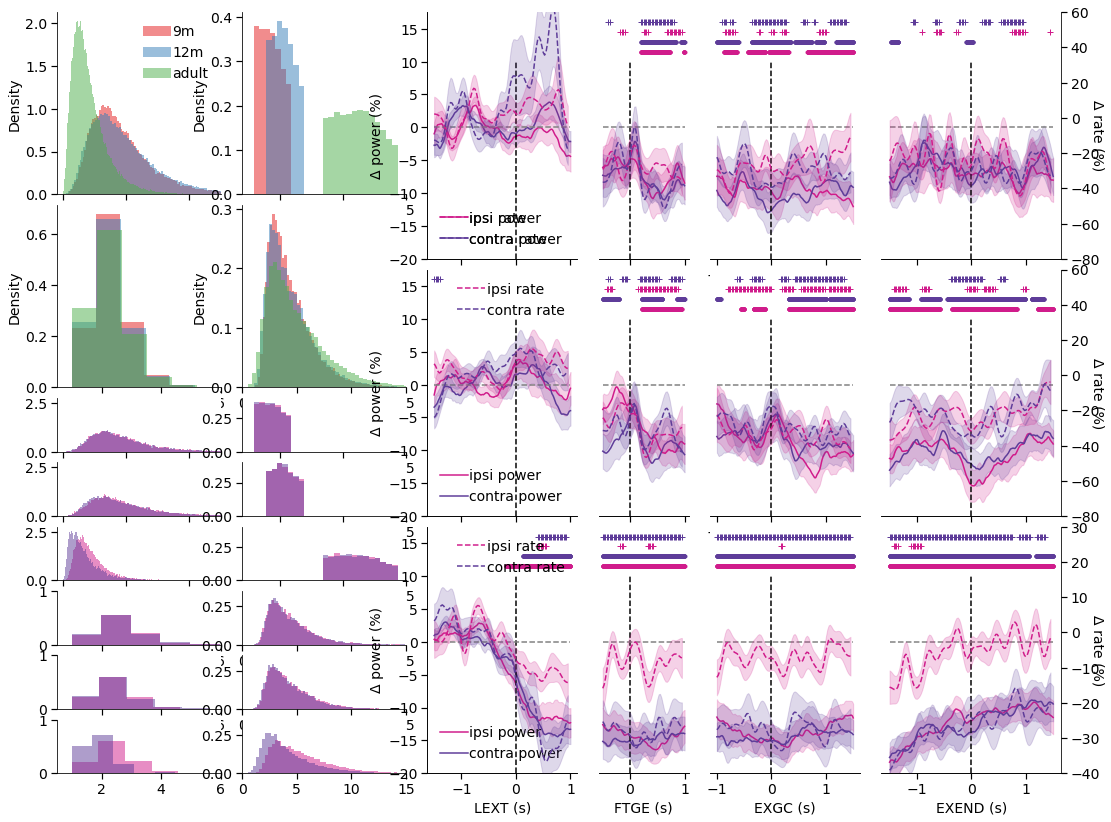

In [18]:
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})


threshold_tfce = dict(start=0, step=0.01)
sigma = 1e-3
hat_corr = partial(ttest_1samp_no_p, sigma=sigma)

buffer=125
bin_dt=25

rate_color=np.array([208,28,139,255])/255.0
power_color=np.array([94,60,153,255])/255.0
nine_color=np.array([228,26,28])/255.0
twelve_color=np.array([55,126,184])/255.0
adult_color=np.array([77,175,74])/255.0
ipsi_color=np.array([208,28,139,255])/255.0
contra_color=np.array([94,60,153,255])/255.0

fig=plt.figure(figsize=(18,14))
gs = fig.add_gridspec(12,8,width_ratios=[.083325,.083325,.083325,.083325, 
                                        0.17544737, 0.10526842, 0.17544737, 0.21053684])

ax = fig.add_subplot(gs[0:3, 0:2])
_=plt.hist(c_bursts_9m['peak_amp_base']*1e6,500,alpha=.5,label='9m', density=True, color=nine_color)
_=plt.hist(c_bursts_12m['peak_amp_base']*1e6,500,alpha=.5,label='12m', density=True, color=twelve_color)
_=plt.hist(c_bursts_adult['peak_amp_base']*1e6,500,alpha=.5,label='adult', density=True, color=adult_color)
ax.set_xlim([-.1,2.5])
ax.set_xlabel('Peak amplitude (µV)')
ax.set_ylabel('Density')
ax.legend()

ax = fig.add_subplot(gs[0:3, 2:4])
_=plt.hist(c_bursts_9m['peak_freq'],7,alpha=.5, density=True, color=nine_color)
_=plt.hist(c_bursts_12m['peak_freq'],7,alpha=.5, density=True, color=twelve_color)
_=plt.hist(c_bursts_adult['peak_freq'],13,alpha=.5, density=True, color=adult_color)
ax.set_xlim([12, 25])
ax.set_xlabel('Peak frequency (Hz)')
ax.set_ylabel('Density')

ax = fig.add_subplot(gs[3:6, 0:2])
_=plt.hist(c_bursts_9m['fwhm_freq'],11,alpha=.5, density=True, color=nine_color)
_=plt.hist(c_bursts_12m['fwhm_freq'],18,alpha=.5, density=True, color=twelve_color)
_=plt.hist(c_bursts_adult['fwhm_freq'],13,alpha=.5, density=True, color=adult_color)
ax.set_xlim([0.5,6])
ax.set_xlabel('Frequency span (Hz)')
ax.set_ylabel('Density')

ax = fig.add_subplot(gs[3:6, 2:4])
_=plt.hist(c_bursts_9m['fwhm_time']/(1000/c_bursts_9m['peak_freq']),100,alpha=.5, density=True, color=nine_color)
_=plt.hist(c_bursts_12m['fwhm_time']/(1000/c_bursts_12m['peak_freq']),100,alpha=.5, density=True, color=twelve_color)
_=plt.hist(c_bursts_adult['fwhm_time']/(1000/c_bursts_adult['peak_freq']),100,alpha=.5, density=True, color=adult_color)
ax.set_xlim([0,15])
ax.set_xlabel('Duration (cycles)')
ax.set_ylabel('Density')

ax = fig.add_subplot(gs[6, 0:2])
_=plt.hist(exe_c_bursts_9m['peak_amp_base'][(exe_c_bursts_9m['cluster']=='ipsi')]*1e6,
           500,alpha=.5, density=True, color=ipsi_color)
_=plt.hist(exe_c_bursts_9m['peak_amp_base'][(exe_c_bursts_9m['cluster']=='contra')]*1e6,
           500,alpha=.5, density=True, color=contra_color)
ax.set_xlim([-.1,2.5])
ax.set_ylim([0,2.75])
ax = fig.add_subplot(gs[7, 0:2])
_=plt.hist(exe_c_bursts_12m['peak_amp_base'][(exe_c_bursts_12m['cluster']=='ipsi')]*1e6,
           500,alpha=.5, density=True, color=ipsi_color)
_=plt.hist(exe_c_bursts_12m['peak_amp_base'][(exe_c_bursts_12m['cluster']=='contra')]*1e6,
           500,alpha=.5, density=True, color=contra_color)
ax.set_xlim([-.1,2.5])
ax.set_ylim([0,2.75])
ax = fig.add_subplot(gs[8, 0:2])
_=plt.hist(exe_c_bursts_adult['peak_amp_base'][(exe_c_bursts_adult['cluster']=='ipsi')]*1e6,
           500,alpha=.5, density=True, color=ipsi_color)
_=plt.hist(exe_c_bursts_adult['peak_amp_base'][(exe_c_bursts_adult['cluster']=='contra')]*1e6,
           500,alpha=.5, density=True, color=contra_color)
ax.set_xlim([-.1,2.5])
ax.set_ylim([0,2.75])

ax = fig.add_subplot(gs[6, 2:4])
_=plt.hist(exe_c_bursts_9m['peak_freq'][(exe_c_bursts_9m['cluster']=='ipsi')],
           7,alpha=.5, density=True, color=ipsi_color)
_=plt.hist(exe_c_bursts_9m['peak_freq'][(exe_c_bursts_9m['cluster']=='contra')],
           7,alpha=.5, density=True, color=contra_color)
ax.set_xlim([12, 25])
ax.set_ylim([0,.4])
ax = fig.add_subplot(gs[7, 2:4])
_=plt.hist(exe_c_bursts_12m['peak_freq'][(exe_c_bursts_12m['cluster']=='ipsi')],
           7,alpha=.5, density=True, color=ipsi_color)
_=plt.hist(exe_c_bursts_12m['peak_freq'][(exe_c_bursts_12m['cluster']=='contra')],
           7,alpha=.5, density=True, color=contra_color)
ax.set_xlim([12, 25])
ax.set_ylim([0,.4])
ax = fig.add_subplot(gs[8, 2:4])
_=plt.hist(exe_c_bursts_adult['peak_freq'][(exe_c_bursts_adult['cluster']=='ipsi')],
           13,alpha=.5, density=True, color=ipsi_color)
_=plt.hist(exe_c_bursts_adult['peak_freq'][(exe_c_bursts_adult['cluster']=='contra')],
           13,alpha=.5, density=True, color=contra_color)
ax.set_xlim([12, 25])
ax.set_ylim([0,.4])

ax = fig.add_subplot(gs[9, 0:2])
_=plt.hist(exe_c_bursts_9m['fwhm_freq'][(exe_c_bursts_9m['cluster']=='ipsi')],
           8,alpha=.5, density=True, color=ipsi_color)
_=plt.hist(exe_c_bursts_9m['fwhm_freq'][(exe_c_bursts_9m['cluster']=='contra')],
           7,alpha=.5, density=True, color=contra_color)
ax.set_xlim([0.5,6])
ax.set_ylim([0,1])
ax = fig.add_subplot(gs[10, 0:2])
_=plt.hist(exe_c_bursts_12m['fwhm_freq'][(exe_c_bursts_12m['cluster']=='ipsi')],
           12,alpha=.5, density=True, color=ipsi_color)
_=plt.hist(exe_c_bursts_12m['fwhm_freq'][(exe_c_bursts_12m['cluster']=='contra')],
           15,alpha=.5, density=True, color=contra_color)
ax.set_xlim([0.5,6])
ax.set_ylim([0,1])
ax = fig.add_subplot(gs[11, 0:2])
_=plt.hist(exe_c_bursts_adult['fwhm_freq'][(exe_c_bursts_adult['cluster']=='ipsi')],
           10,alpha=.5, density=True, color=ipsi_color)
_=plt.hist(exe_c_bursts_adult['fwhm_freq'][(exe_c_bursts_adult['cluster']=='contra')],
           10,alpha=.5, density=True, color=contra_color)
ax.set_xlim([0.5,6])
ax.set_ylim([0,1])

ax = fig.add_subplot(gs[9, 2:4])
dur_cycles_9m=exe_c_bursts_9m['fwhm_time']/(1000/exe_c_bursts_9m['peak_freq'])
_=plt.hist(dur_cycles_9m[(exe_c_bursts_9m['cluster']=='ipsi')],
           100,alpha=.5, density=True, color=ipsi_color)
_=plt.hist(dur_cycles_9m[(exe_c_bursts_9m['cluster']=='contra')],
           100,alpha=.5, density=True, color=contra_color)
ax.set_xlim([0,15])
ax.set_ylim([0,.35])
ax = fig.add_subplot(gs[10, 2:4])
dur_cycles_12m=exe_c_bursts_12m['fwhm_time']/(1000/exe_c_bursts_12m['peak_freq'])
_=plt.hist(dur_cycles_12m[(exe_c_bursts_12m['cluster']=='ipsi')],
           100,alpha=.5, density=True, color=ipsi_color)
_=plt.hist(dur_cycles_12m[(exe_c_bursts_12m['cluster']=='contra')],
           100,alpha=.5, density=True, color=contra_color)
ax.set_xlim([0,15])
ax.set_ylim([0,.35])
ax = fig.add_subplot(gs[11, 2:4])
dur_cycles_adult=exe_c_bursts_adult['fwhm_time']/(1000/exe_c_bursts_adult['peak_freq'])
_=plt.hist(dur_cycles_adult[(exe_c_bursts_adult['cluster']=='ipsi')],
           100,alpha=.5, density=True, color=ipsi_color)
_=plt.hist(dur_cycles_adult[(exe_c_bursts_adult['cluster']=='contra')],
           100,alpha=.5, density=True, color=contra_color)
ax.set_xlim([0,15])
ax.set_ylim([0,.35])

def plot_power_rate(axs,
                    epoch_time, yl_pow, ipsi_tfs, contra_tfs, 
                    epoch_bins, yl_rate, ipsi_rates, contra_rates, 
                    condition, xlabel=True, stats=True):

    if condition=='exe':
        labels=['ipsi','contra']
    else:
        labels=['C3','C4']
    epochs=condition_epochs[condition]
    
    for e_idx,epoch in enumerate(epochs):        
        ax1=axs[e_idx]
        m_ipsi_pow=np.mean(ipsi_tfs[epoch],axis=0)
        se_ipsi_pow=np.std(ipsi_tfs[epoch],axis=0)/np.sqrt(ipsi_tfs[epoch].shape[0])
        m_contra_pow=np.mean(contra_tfs[epoch],axis=0)
        se_contra_pow=np.std(contra_tfs[epoch],axis=0)/np.sqrt(contra_tfs[epoch].shape[0])
        t_pow=epoch_time[epoch]/1000
        ax1.fill_between(t_pow,m_ipsi_pow-se_ipsi_pow,m_ipsi_pow+se_ipsi_pow,alpha=0.2,color=ipsi_color)
        ax1.plot(t_pow,m_ipsi_pow,label='{} power'.format(labels[0]),color=ipsi_color)
        ax1.fill_between(t_pow,m_contra_pow-se_contra_pow,m_contra_pow+se_contra_pow,alpha=0.2,color=contra_color)
        ax1.plot(t_pow,m_contra_pow,label='{} power'.format(labels[1]),color=contra_color)

        ax2=ax1.twinx()
        m_ipsi_rate=np.nanmean(ipsi_rates[epoch],axis=0)
        se_ipsi_rate=np.nanstd(ipsi_rates[epoch],axis=0)/np.sqrt(ipsi_rates[epoch].shape[0])
        m_contra_rate=np.nanmean(contra_rates[epoch],axis=0)
        se_contra_rate=np.nanstd(contra_rates[epoch],axis=0)/np.sqrt(contra_rates[epoch].shape[0])
        t_rate=epoch_bins[epoch]/1000
        ax2.fill_between(t_rate,m_ipsi_rate-se_ipsi_rate,m_ipsi_rate+se_ipsi_rate,alpha=0.2,color=ipsi_color)
        ax2.plot(t_rate,m_ipsi_rate,'--',label='{} rate'.format(labels[0]),color=ipsi_color)
        ax2.fill_between(t_rate,m_contra_rate-se_contra_rate,m_contra_rate+se_contra_rate,alpha=0.2,color=contra_color)
        ax2.plot(t_rate,m_contra_rate,'--',label='{} rate'.format(labels[1]),color=contra_color)

        pos_range_pow=yl_pow[1]
        pos_range_rate=yl_rate[1]

        if stats:
            power_ipsi_T_HAT, _, power_ipsi_P_HAT, _ = permutation_cluster_1samp_test(
                ipsi_tfs[epoch], stat_fun = hat_corr,
                threshold = threshold_tfce, n_permutations=1000, n_jobs=-1,
                out_type="mask", verbose=False, adjacency=None, buffer_size=None
            )

            power_contra_T_HAT, _, power_contra_P_HAT, _ = permutation_cluster_1samp_test(
                contra_tfs[epoch], stat_fun = hat_corr,
                threshold = threshold_tfce, n_permutations=1000, n_jobs=-1,
                out_type="mask", verbose=False, adjacency=None, buffer_size=None
            )

            rate_ipsi_T_HAT, _, rate_ipsi_P_HAT, _ = permutation_cluster_1samp_test(
                ipsi_rates[epoch], stat_fun = hat_corr,
                threshold = threshold_tfce, n_permutations=1000, n_jobs=-1,
                out_type="mask", verbose=False, adjacency=None, buffer_size=None
            )

            rate_contra_T_HAT, _, rate_contra_P_HAT, _ = permutation_cluster_1samp_test(
                contra_rates[epoch], stat_fun = hat_corr,
                threshold = threshold_tfce, n_permutations=1000, n_jobs=-1,
                out_type="mask", verbose=False, adjacency=None, buffer_size=None
            )

            for i in range(len(t_pow)):
                if power_ipsi_P_HAT[i]<0.05:
                    ax1.plot(t_pow[i],yl_pow[1]+1*.15*pos_range_pow, '.', color=ipsi_color)

            for i in range(len(t_pow)):
                if power_contra_P_HAT[i]<0.05:
                    ax1.plot(t_pow[i],yl_pow[1]+2*.15*pos_range_pow, '.',color=contra_color)

            for i in range(len(t_rate)):
                if rate_ipsi_P_HAT[i]<0.05:
                    ax1.plot(t_rate[i],yl_pow[1]+3*.15*pos_range_pow, '+', color=ipsi_color)

            for i in range(len(t_rate)):
                if rate_contra_P_HAT[i]<0.05:
                    ax1.plot(t_rate[i],yl_pow[1]+4*.15*pos_range_pow, '+',color=contra_color)

        if e_idx==0:
            ax1.set_ylabel('Δ power (%)')
            ax1.legend()
            ax2.legend()
        if e_idx==len(epochs)-1:
            ax2.set_ylabel('Δ rate (%)', rotation=-90)

        ax1.plot([0,0],yl_pow,'k--')
        ax1.plot(t_pow[[0,-1]],[0,0],'--',color=[.5,.5,.5])
        new_yl_pow=[yl_pow[0], yl_pow[1]+5*.15*pos_range_pow]
        ax1.set_ylim(new_yl_pow)    
        ax2.set_ylim(yl_rate)    
        
        if e_idx>0 and e_idx<len(epochs)-1:
            ax1.spines[['left','right']].set_visible(False)
            ax1.tick_params(labelleft=False,left=False,labelright=False,right=False)
            ax2.spines[['left','right']].set_visible(False)
            ax2.tick_params(labelleft=False,left=False,labelright=False,right=False)
        elif e_idx==0:
            ax1.spines[['right']].set_visible(False)
            ax1.tick_params(labelright=False,right=False)
            ax2.spines[['right']].set_visible(False)
            ax2.tick_params(labelright=False,right=False)
        else:
            ax1.spines[['left']].set_visible(False)
            ax1.tick_params(labelleft=False,left=False)
            ax2.spines[['left']].set_visible(False)
            ax2.tick_params(labelleft=False,left=False)
            ax2.spines[['right']].set_visible(True)
            ax2.tick_params(labelright=True,right=True)
        
        if xlabel:
            ax1.set_xlabel('{} (s)'.format(epoch))    
    
 
yl_pow=[-20,10]
yl_rate=[-80, 60]
axs=[]
stats=True
for i in range(4,8):
    axs.append(fig.add_subplot(gs[0:4,i]))
plot_power_rate(axs,
                exe_epoch_time_9m, yl_pow, c_exe_ipsi_tfs_9m, c_exe_contra_tfs_9m, 
                exe_epoch_bins_9m, yl_rate, c_exe_ipsi_rates_9m, c_exe_contra_rates_9m,
                'exe', xlabel=False, stats=stats)

axs=[]
for i in range(4,8):
    axs.append(fig.add_subplot(gs[4:8,i]))
plot_power_rate(axs,
                exe_epoch_time_12m, yl_pow, c_exe_ipsi_tfs_12m, c_exe_contra_tfs_12m, 
                exe_epoch_bins_12m, yl_rate, c_exe_ipsi_rates_12m, c_exe_contra_rates_12m,
                'exe', xlabel=False, stats=stats)

yl_pow=[-20,10]
yl_rate=[-40, 30]
axs=[]
for i in range(4,8):
    axs.append(fig.add_subplot(gs[8:12,i]))
plot_power_rate(axs,
                exe_epoch_time_adult, yl_pow, c_exe_ipsi_tfs_adult, c_exe_contra_tfs_adult, 
                exe_epoch_bins_adult, yl_rate, c_exe_ipsi_rates_adult, c_exe_contra_rates_adult,
                'exe', xlabel=True, stats=stats)

fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure5.svg', bbox_inches="tight")
fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure5.png', bbox_inches="tight")


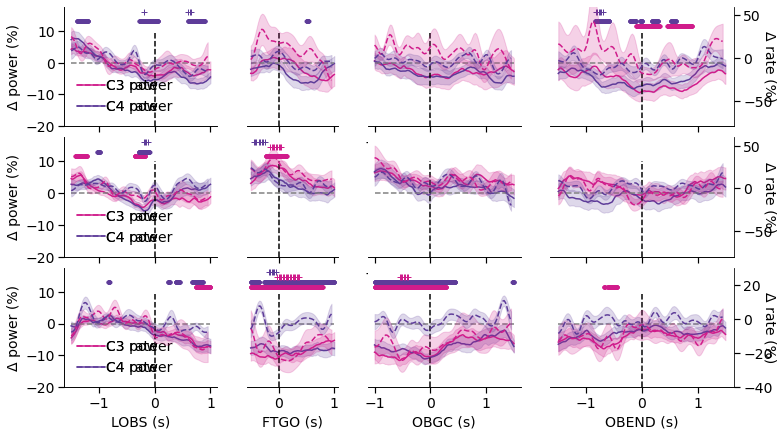

In [19]:
fig=plt.figure(figsize=(12,7), facecolor='w')
gs = fig.add_gridspec(6,4,width_ratios=[0.17544737, 0.10526842, 0.17544737, 0.21053684])
yl_pow=[-20,10]
yl_rate=[-80, 60]
axs=[]
for i in range(0,4):
    axs.append(fig.add_subplot(gs[0:2,i]))
plot_power_rate(axs,obs_epoch_time_9m, yl_pow, c_obs_ipsi_tfs_9m, c_obs_contra_tfs_9m, obs_epoch_bins_9m, yl_rate, c_obs_ipsi_rates_9m, c_obs_contra_rates_9m,'obs')
yl_pow=[-20,10]
yl_rate=[-80, 60]
axs=[]
for i in range(0,4):
    axs.append(fig.add_subplot(gs[2:4,i]))
plot_power_rate(axs,obs_epoch_time_12m, yl_pow, c_obs_ipsi_tfs_12m, c_obs_contra_tfs_12m, obs_epoch_bins_12m, yl_rate, c_obs_ipsi_rates_12m, c_obs_contra_rates_12m,'obs')
yl_pow=[-20,10]
yl_rate=[-40, 30]
axs=[]
for i in range(0,4):
    axs.append(fig.add_subplot(gs[4:6,i]))
plot_power_rate(axs,obs_epoch_time_adult, yl_pow, c_obs_ipsi_tfs_adult, c_obs_contra_tfs_adult, obs_epoch_bins_adult, yl_rate, c_obs_ipsi_rates_adult, c_obs_contra_rates_adult,'obs')
